### <span style="color:orange"> Install CUDA (GPU drivers from NVIDIA) </span>

- import Pkg; Pkg.add("CUDA");

In [8]:
#import Pkg; Pkg.add("CUDA");
using CUDA

#### By default, Flux will run the checks on your system to see if it can support GPU functionality. You can check if Flux identified a valid GPU setup by typing the following:

In [9]:
CUDA.functional() #check if Flux can find your GPU

false

#### you need to **->move<-** <u>model weights</u> and <u>data</u> to the GPU and Flux will handle it.

- you need to tell Flux that the weights and the data need to go to the GPU to be used in the computation by the GPU

In [10]:
using Flux, Statistics, ProgressMeter
using Plots 
using StatsBase, Random

## <span style="color:orange"> Keyword `gpu` is a function to put models and data onto the GPU </span>

- Float32 is the typical single precision on GPUs

In [11]:
using RDatasets
iris = dataset("datasets", "iris");

In [12]:
typeof(iris)
display( iris[1:3,:])

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa


In [13]:
features = iris[:,1:4]
features = Matrix{Float32}(features) 
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [14]:
length( unique( iris[:,end] ) )

3

In [15]:
length( iris[:,end] )

150

In [16]:
odd_inds = findall( mod.(1:150,2) .== 1)
even_inds = findall( mod.(1:150,2) .== 0);

In [17]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( "x_train size before ", size(x_train) )
x_train = x_train'
x_test = x_test'
println( "x_train size after ", size(x_train) )

x_train size before (75, 4)
x_train size after (4, 75)


In [18]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 75)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [19]:
#put onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

    
- if a GPU is -not- present it will do nothing, it runs on the GPU if the library CUDA.jl loads successfully 
- this function moves data to the GPU from the CPU space  
                    
![by Damien Benveniste ](./images/cpugputpu.jpg)

(TPUs are not recommended to sequential models like LSTMs and they require longer runs to derive benefit over the GPU)

In [20]:
#make a model for predicting the species (categorical output)
model_iris = Chain( Dense( 4=>8, relu ) , Dense( 8=>3 ) , softmax ) |> gpu

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3),                        # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

### <span style="color:orange"> The data and model is brought back from the GPU to the CPU with the function `cpu` </span>

- if the data has been moved to the GPU it is necessary to run `cpu` in order to do things like plot the data

In [21]:
#put back onto the CPU
species |> gpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [22]:
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.2850011, 0.2288965, 0.48610246]
category output predicted ('one-cold') = virginica
true output label = setosa
cross entropy of prediction and target = 1.2552618
cross entropy of predictions and multiple targets = 1.2661333
init accuracy = 30.666666666666668%


In [23]:
#put back onto the GPU
species |> gpu
x_train |> gpu
x_test |> gpu
y_train |> gpu
y_test |> gpu

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [24]:
#pack the data and put onto the gpu
data = Flux.DataLoader( (x_train, y_train) , batchsize=20 , shuffle=true ) |> gpu

4-element DataLoader(::Tuple{LinearAlgebra.Adjoint{Float32, Matrix{Float32}}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=20)
  with first element:
  (4×20 Matrix{Float32}, 3×20 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

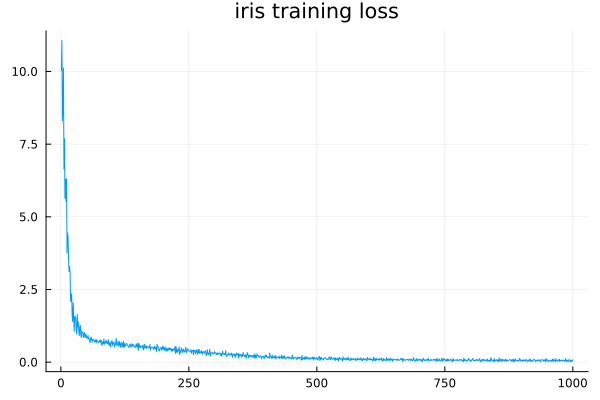

In [25]:
#train the parameters to predict iris
model_iris = Chain( Dense( 4=>8, relu ) , Dense( 8=>3 ) , softmax ) |> gpu
opt = Flux.setup( Flux.Adam(0.01) , model_iris ) |> gpu
losses = []
for epoch in 1:250
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [26]:
model_iris |> cpu
species |> cpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%" )

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%" )

Iris train accuracy = 100.0%
Iris test accuracy = 94.66666666666667%


## <span style="color:orange"> Try the same thing but modify only the activation function in the second layer from identity to become sigmoid </span>

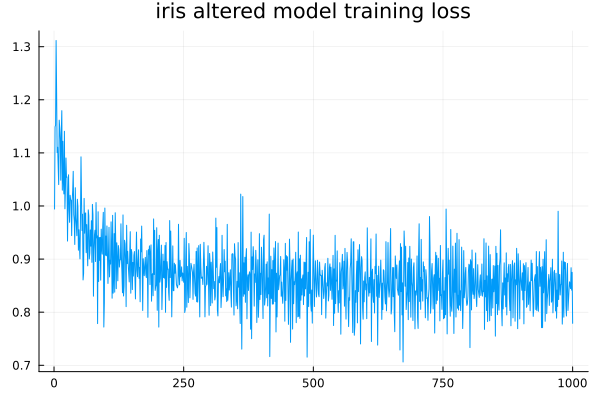

In [27]:
#train the parameters to predict iris
model_iris2 = Chain( Dense( 4=>8, relu ) , Dense( 8=>3 , sigmoid ) , softmax ) |> gpu
opt = Flux.setup( Flux.Adam(0.01) , model_iris2 ) |> gpu
losses = []
for epoch in 1:250
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris2) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!( opt , model_iris2 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot( losses , title="iris altered model training loss" , legend=false )
#savefig("./p1.png") #save the plot in the current directory
display(p1)

In [28]:
model_iris |> cpu
species |> cpu
x_train |> cpu
x_test |> cpu
y_train |> cpu
y_test |> cpu

hits = Flux.onecold( model_iris2( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris train accuracy = ", accuracy , "%" )

hits = Flux.onecold( model_iris2( x_test ) , species ) .== Flux.onecold( y_test , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "Iris test accuracy = ", accuracy , "%" )

Iris train accuracy = 33.333333333333336%
Iris test accuracy = 33.333333333333336%


In [29]:
#import Pkg; Pkg.add("MLDatasets")
#import Pkg; Pkg.add("ImageInTerminal")
#import Pkg; Pkg.add("ImageShow")
#import Pkg; Pkg.add("Images")
#import Pkg; Pkg.add("ImageIO")
#import Pkg; Pkg.add("ImageMagick")
using ImageShow, Images, ImageInTerminal
using MLDatasets

In [30]:
train_x_raw, train_y_raw = MNIST(split = :train)[:]
test_x_raw,  test_y_raw  = MNIST(split = :test)[:];
println( "train_x_raw size = $(size(train_x_raw)), train_y_raw size = $(size(train_y_raw))")
display( train_y_raw[1:5] )

train_x_raw size = (28, 28, 60000), train_y_raw size = (60000,)


5-element Vector{Int64}:
 5
 0
 4
 1
 9

[5, 0, 4, 1, 9]


,,,,

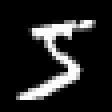
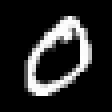
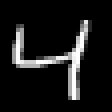
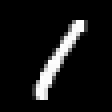
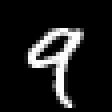

In [31]:
println( [ train_y_raw[ ii ] for ii in 1:5 ] )
[ convert2image(MNIST, train_x_raw[ : , : , ii ] ) for ii in 1:5 ]

[5, 0, 4, 1, 9]


,,,,

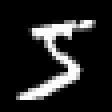
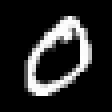
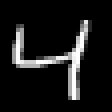
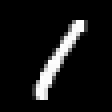
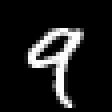

In [32]:
#color view needs the transpose since the x and y are flipped
println( [ train_y_raw[ ii ] for ii in 1:5 ] )
[ colorview( Gray , train_x_raw[ : , : , ii ]' ) for ii in 1:5 ]

In [33]:
#make the data from matrix to vector
train_x = Flux.flatten(train_x_raw)
test_x = Flux.flatten(test_x_raw)
println( "size of train_x = $(size(train_x))")
println( "28 x 28 = $(28*28)")

size of train_x = (784, 60000)
28 x 28 = 784


In [34]:
train_y = Flux.onehotbatch( train_y_raw , 0:9 )
test_y  = Flux.onehotbatch( test_y_raw , 0:9 )
println( "size of train_y = $(size(train_y))" )
println( "unique train_y_raw = $(unique(train_y_raw))" )
display( train_y[ : , 1:3 ] )

size of train_y = (10, 60000)
unique train_y_raw = [5, 0, 4, 1, 9, 2, 3, 6, 7, 8]


10×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  1
 1  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅

In [35]:
model_digits = Chain( Dense( 28*28=>60 , sigmoid) , Dense( 60=>32 , relu ) , Dense( 32=>10 , relu ) , softmax ) 

Chain(
  Dense(784 => 60, σ),                  # 47_100 parameters
  Dense(60 => 32, relu),                # 1_952 parameters
  Dense(32 => 10, relu),                # 330 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 49_382 parameters, 193.273 KiB.

In [36]:
#test the model at init ( untrained ) on 1 image
model_digits( train_x[:,1] )

10-element Vector{Float32}:
 0.09297345
 0.09297345
 0.09297345
 0.09297345
 0.09297345
 0.09297345
 0.09297345
 0.11084697
 0.09297345
 0.14536546

In [37]:
#test the model at init ( untrained ) on 3 images
model_digits( train_x[:,1:3] )

10×3 Matrix{Float32}:
 0.0929735  0.106838   0.0939079
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.110847   0.124017   0.115146
 0.0929735  0.0875074  0.0884364
 0.145365   0.156594   0.171891

In [38]:
#convert outputs to labels via one cold
Flux.onecold( model_digits(train_x[:,1]) , 0:9 )

9

In [39]:
#initial accuracy of untrained model
model_digits( train_x[:,1:3] )

10×3 Matrix{Float32}:
 0.0929735  0.106838   0.0939079
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.0929735  0.0875074  0.0884364
 0.110847   0.124017   0.115146
 0.0929735  0.0875074  0.0884364
 0.145365   0.156594   0.171891

In [40]:
Flux.onecold( model_digits(train_x[:,1:3]) , 0:9 )

3-element Vector{Int64}:
 9
 9
 9

7


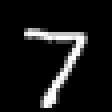

In [41]:
#look at the label in onecold and the corresponding image
println( Flux.onecold( test_y[:,1] , 0:9 ) )
colorview( Gray , test_x_raw[ : , : , 1 ]' )

In [42]:
data_digits = Flux.DataLoader( (train_x, train_y) , batchsize=5 , shuffle=true )

12000-element DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=5)
  with first element:
  (784×5 Matrix{Float32}, 10×5 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

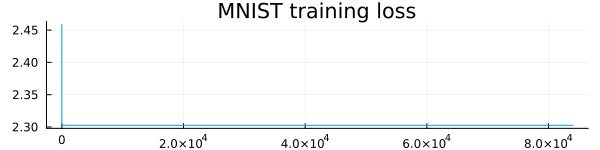

In [43]:

data_digits |> gpu
model_digits = Chain( Dense( 28*28=>60 , sigmoid) , Dense( 60=>32 , relu ) , Dense( 32=>10 , relu ) , softmax ) |> gpu
opt = Flux.setup( Flux.Adam(0.01) , model_digits );

losses = []
for epoch in 1:7
    
    #make the step size smaller after a certain point of time
    if( epoch == 4 ) Flux.adjust!( opt , 0.001 ) end
    
    for ( x , y ) in data_digits    
        
        loss_tmp, grads = Flux.withgradient( model_digits ) do model                        
                
            y_hat = model( x )
            loss = Flux.crossentropy( y_hat , y )
            return loss
            
        end     
        Flux.update!( opt , model_digits , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
#     break
end
p1 = plot( losses , title="MNIST training loss" , legend=false , size=(600,150) )
savefig(p1,"p1.png")
display(p1)

In [44]:

test_y_labels = Flux.onecold( test_y , 0:9 )

test_res = model_digits( test_x )
test_res_labels = Flux.onecold( test_res , 0:9 )
println( size( test_res_labels ) )
println( size( test_y_labels ) )

model_digits |> cpu
println( "accuracy = ", 100 * (sum( test_res_labels .== test_y_labels ) / length( test_y_labels ) ) , "%" )

(10000,)
(10000,)
accuracy = 9.8%


[LeNet5](https://en.wikipedia.org/wiki/LeNet) 

- The original used the sigmoid but modern versions use the RELU
- [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) . This is LeNet5 original paper by Yann LeCunn and others.
- This example demonstrates Flux’s Convolution and pooling layers

In [45]:
data_digits = Flux.DataLoader( (train_x_raw, train_y_raw) , batchsize=5 , shuffle=true ) 

12000-element DataLoader(::Tuple{Array{Float32, 3}, Vector{Int64}}, shuffle=true, batchsize=5)
  with first element:
  (28×28×5 Array{Float32, 3}, 5-element Vector{Int64},)

In [46]:
function LeNet5(; imgsize=(28,28,1), nclasses=10) 
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    println(prod(out_conv_size))
    
    return Chain(
            Conv((5, 5), imgsize[end]=>6, relu) , 
            MaxPool((2, 2)), 
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            Flux.flatten,
            Dense(prod(out_conv_size) => 120, relu), 
            Dense(120 => 84, relu), 
            Dense(84 => 10)
          )
end
model = LeNet5() 
opt = Flux.setup( Flux.Adam(0.001) , model );

256


In [47]:
x , y = first( data_digits )
println( size(x) )
println( size( Flux.unsqueeze(x,dims=3) ) )
batch_tmp = Flux.unsqueeze(x,dims=3)
res_tmp = model(batch_tmp)
display( res_tmp )
println( model(batch_tmp) )
println( size( res_tmp ) )
println( Flux.onecold( res_tmp , 0:9 ) )

(28, 28, 5)
(28, 28, 1, 5)


10×5 Matrix{Float32}:
  0.104839     0.0815143    0.127833     0.111052    0.0708434
 -5.21513f-5   0.0035146    0.031496    -0.0160537   0.0111075
  0.11701      0.108564     0.125734     0.0654359   0.0965276
  0.0125058   -0.0395109   -0.00188671   0.0221481  -0.0077765
 -0.0964066   -0.187976    -0.109243    -0.100573   -0.123734
  0.030691    -0.00598974  -0.012889    -0.0128164   0.0281887
  0.13756      0.150613     0.106764     0.163729    0.109751
  0.0593748    0.0602723    0.0918934    0.110715    0.0483173
 -0.10146     -0.0842719   -0.156679    -0.13112    -0.0998642
  0.0716103    0.116411     0.122075     0.0528681   0.0471978

Float32[0.10483865 0.08151432 0.12783301 0.11105235 0.07084344; -5.215127f-5 0.0035146037 0.03149603 -0.016053692 0.011107547; 0.11700995 0.108563885 0.12573443 0.065435946 0.09652763; 0.012505767 -0.039510943 -0.0018867105 0.022148069 -0.007776504; -0.096406594 -0.18797609 -0.10924299 -0.10057281 -0.12373424; 0.030690992 -0.0059897443 -0.012888966 -0.012816382 0.028188663; 0.13755989 0.15061346 0.10676399 0.16372904 0.10975108; 0.059374772 0.06027229 0.09189337 0.1107147 0.048317257; -0.101460434 -0.084271915 -0.15667945 -0.1311202 -0.09986419; 0.07161033 0.11641087 0.12207529 0.05286814 0.04719783]
(10, 5)
[6, 6, 0, 6, 6]


In [48]:
tmp = reshape( x, (28, 28, 1, :)) # WHCN
println( size( tmp ) )
display( model( tmp ) )

(28, 28, 1, 5)


10×5 Matrix{Float32}:
  0.104839     0.0815143    0.127833     0.111052    0.0708434
 -5.21513f-5   0.0035146    0.031496    -0.0160537   0.0111075
  0.11701      0.108564     0.125734     0.0654359   0.0965276
  0.0125058   -0.0395109   -0.00188671   0.0221481  -0.0077765
 -0.0964066   -0.187976    -0.109243    -0.100573   -0.123734
  0.030691    -0.00598974  -0.012889    -0.0128164   0.0281887
  0.13756      0.150613     0.106764     0.163729    0.109751
  0.0593748    0.0602723    0.0918934    0.110715    0.0483173
 -0.10146     -0.0842719   -0.156679    -0.13112    -0.0998642
  0.0716103    0.116411     0.122075     0.0528681   0.0471978

In [49]:
data_digits = Flux.DataLoader( (train_x_raw, train_y_raw) , batchsize=125 , shuffle=true );

In [50]:
model |> gpu
data_digits |> gpu;

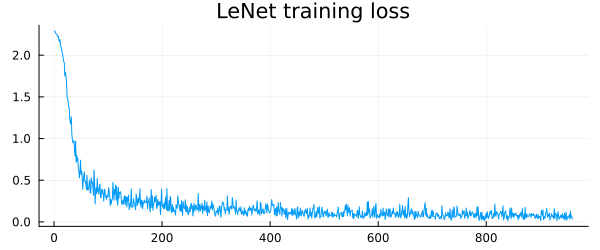

In [51]:

losses = []
for epoch in 1:2
        
    for ( x , y ) in data_digits    
        
        #println( "size x=$(size(x)) size y=$(size(y))" )
        x_batch_tmp = Flux.unsqueeze(x,dims=3)
        y_batch_tmp = Flux.onehotbatch( y , 0:9 )
        #println( "size x_batch_tmp=$(size(x_batch_tmp)) size y_batch_tmp=$(size(y_batch_tmp))" )
        
        loss_tmp, grads = Flux.withgradient( model ) do model                        
            #println( "ok1" )
            y_hat = model( x_batch_tmp )
            
            #println( "size y_hat=$(size(y_hat))" )
            loss = Flux.logitcrossentropy( y_hat , y_batch_tmp ) #logitcrossentropy since softmax is not applied at the end of the model
            return loss
            
        end     
#         break
        Flux.update!( opt , model , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
#     break
end
p1 = plot( losses , title="LeNet training loss" , legend=false , size=(600,250) )
savefig(p1,"p1.png")
display(p1)

In [52]:
xtest_batch = Flux.unsqueeze(test_x_raw,dims=3)
size(xtest_batch)

(28, 28, 1, 10000)

In [53]:
model |> cpu

test_res = model( xtest_batch )
println(size(test_res))
test_res_labels = Flux.onecold( test_res , 0:9 )

test_y_labels = Flux.onecold( test_y , 0:9 )
println( size( test_res_labels ) )
println( size( test_y_labels ) )

println( "accuracy = " , 100 * (sum( test_res_labels .== test_y_labels ) / length( test_y_labels ) ) , "%" )

(10, 10000)
(10000,)
(10000,)
accuracy = 98.24000000000001%


## <span style="color:orange">now <u>Save</u> the model to be able to load it again in the future and not need to train it again to be able to use it</span>

In [54]:
using BSON: @save, @load
using BSON

In [55]:
#save the model to this filename
@save "./models/MNISTmodel2023.bson" model

In [56]:
#load the model, model name key provided
@load "./models/MNISTmodel2023.bson" model

In [57]:
#run it again with the loaded model MNIST_model
test_res = model( xtest_batch )
println(size(test_res))
test_res_labels = Flux.onecold( test_res , 0:9 )
test_y_labels = Flux.onecold( test_y , 0:9 )
println( size( test_res_labels ) )
println( size( test_y_labels ) )
println( "accuracy = " , 100 * (sum( test_res_labels .== test_y_labels ) / length( test_y_labels ) ) , "%" )

(10, 10000)
(10000,)
(10000,)
accuracy = 98.24000000000001%


In [58]:
BSON.parse( "./models/MNISTmodel2023.bson" )

Dict{Symbol, Any} with 1 entry:
  :model => Dict{Symbol, Any}(:tag=>"struct", :type=>Dict{Symbol, Any}(:tag=>"d…

In [59]:
#give a new key name
BSON.bson( "./models/MNISTmodel2023b.bson" , MNIST_model = model )

In [60]:
BSON.parse( "./models/MNISTmodel2023b.bson" )

Dict{Symbol, Any} with 1 entry:
  :MNIST_model => Dict{Symbol, Any}(:tag=>"struct", :type=>Dict{Symbol, Any}(:t…

In [61]:
#BSON.parse( "modelsMNISTmodel2023.bson" )
@load "./models/MNISTmodel2023b.bson" MNIST_model

In [62]:
#run it again with the loaded model MNIST_model
test_res = MNIST_model( xtest_batch )
println(size(test_res))
test_res_labels = Flux.onecold( test_res , 0:9 )
test_y_labels = Flux.onecold( test_y , 0:9 )
println( size( test_res_labels ) )
println( size( test_y_labels ) )
println( "accuracy = " , 100 * (sum( test_res_labels .== test_y_labels ) / length( test_y_labels ) ) , "%" )

(10, 10000)
(10000,)
(10000,)
accuracy = 98.24000000000001%


In [63]:
dict_bson = BSON.parse( "./models/MNISTmodel2023b.bson" )

Dict{Symbol, Any} with 1 entry:
  :MNIST_model => Dict{Symbol, Any}(:tag=>"struct", :type=>Dict{Symbol, Any}(:t…

In [64]:
string.( collect( keys( dict_bson ) ) )

1-element Vector{String}:
 "MNIST_model"

# <span style="color:orange"> Networks! Our world is a <u>Networked, Interconnected and Interlinked </u> world! </span>

- Networks are very powerful and can be found throughout nature
- Represented in an Adjacency matrix
- Many use cases are common in recommendation systems for social networks, purchases, fraud, and more
- Multi-Head attention in transformers is effectively a graph structure

## <span style="color:orange"> Let us look at the SGC model </span>

#### Wu, F., Souza, A., Zhang, T., Fifty, C., Yu, T., & Weinberger, K. (2019, May). Simplifying graph convolutional networks. In International conference on machine learning (pp. 6861-6871). PMLR.

### $\hat{Y} = \sigma( S^kX\Theta )$

- S is the normalized adjacency matrix
- It is a one shot learner
- X is the features
- $\Theta$ the paramter matrix

In [65]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot
using StatsBase
using Distributions
using OneHotArrays
using Statistics
using InvertedIndices
using ROCAnalysis

In [66]:
function randomPopulateMat(mat,symmetric=true)
    return adjacency_matrix(erdos_renyi( size(mat)[1] , size(mat)[1] ))
end

randomPopulateMat (generic function with 2 methods)

In [67]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [68]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

### generate block diagonal data to experiment with

In [69]:
nn_max = 4
nn_min = 2
NN_set = [10^n for n in nn_min:nn_max];

In [70]:
ER_BA_SF_WS_Block_graphs = Dict()
ER_BA_SF_WS_Block_matrices = Dict()
for nn in 1:length(NN_set)    
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    ER_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) )
    BA_tmp = barabasi_albert( NN_tmp , 8 )
    SF_tmp = static_scale_free( NN_tmp , 8*(NN_tmp) , 4 )
    WS_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) ) #barabasi_albert( NN_tmp , 5 )
    blocks_tmp = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    
    ER_BA_SF_WS_Block_graphs[nn] = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    #now add some edges between the blocks that are the communities
    #>>>>    
    for bb in 1:Int(round(NN_tmp/10))
        for b1 in 0:3
            for b2 in 0:3
                if(b1 < b2)
                    range1 = randperm(NN_tmp)[1] + b1*NN_tmp
                    range2 = randperm(NN_tmp)[1] + b2*NN_tmp
                    add_edge!( ER_BA_SF_WS_Block_graphs[nn] , range1 , range2 )
                end
            end
        end
    end
    #<<<<
    density_nn = LightGraphs.density(ER_BA_SF_WS_Block_graphs[nn])
    println("nn=$(nn), density=$(density_nn)")
end
[ ER_BA_SF_WS_Block_matrices[ii] = Matrix(adjacency_matrix(ER_BA_SF_WS_Block_graphs[ii])) for ii in 1:length(NN_set) ]
ER_BA_SF_WS_Block_graphs

nn=1, density=0.1713131313131313
nn=2, density=0.018190190190190192
nn=3, density=0.001828902890289029


Dict{Any, Any} with 3 entries:
  2 => {1000, 9086} undirected simple Int64 graph
  3 => {10000, 91436} undirected simple Int64 graph
  1 => {100, 848} undirected simple Int64 graph

In [71]:
# check to see if the blocks are 'connected'
[ is_connected( ER_BA_SF_WS_Block_graphs[ii] ) for ii in 1:length(NN_set) ]

3-element Vector{Bool}:
 1
 1
 1

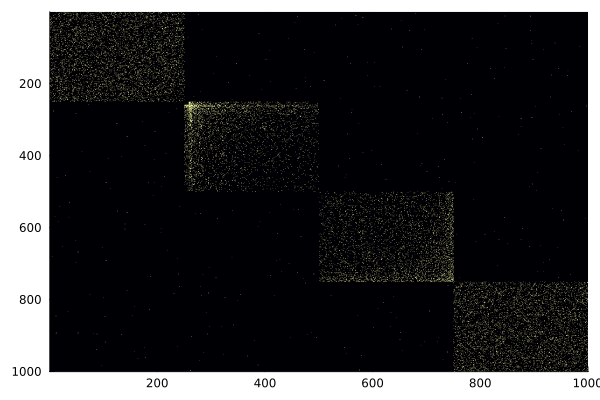

In [72]:
#visualize the adjacency
heatmap( ER_BA_SF_WS_Block_matrices[2] , yflip = true , legend = false )

## generate the X and Y variable data

In [73]:
d1 = Dirichlet( [10,10,10] )
c1 = Categorical( [0.5,0.25,0.25] )
d2 = Dirichlet( [20,10,10] )
c2 = Categorical( [0.35,0.35,0.3] )
d3 = Dirichlet( [20,10,20] )
c3 = Categorical( [0.25,0.25,0.5] )
# d1 = Dirichlet( [10,10] )
# c1 = Categorical( [0.5,0.5] )
# d2 = Dirichlet( [20,10] )
# c2 = Categorical( [0.3,0.7] )
# d3 = Dirichlet( [20,10] )
# c3 = Categorical( [0.7,0.3] )
networks_X = Dict()
networks_Y = Dict()
networks_Y_cold = Dict()

for nn in 1:length(NN_set)
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1a = vcat( xd1 , xc1 )'
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1b = vcat( xd1 , xc1 )'
    xd2 = rand( d2 , NN_tmp )
    xc2 = onehotbatch( rand( c2 , NN_tmp ) , 1:3 )
    x2 = vcat( xd2 , xc2 )'
    xd3 = rand( d3 , NN_tmp )
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'

    networks_X[nn] = vcat( x1a , x1b , x2 , x3 )
    
    y1a = onehotbatch( 1*ones(NN_tmp) , 1:2 )'
    y1b = onehotbatch( 1*ones(NN_tmp) , 1:2 )'
    y2 = onehotbatch( 2*ones(NN_tmp) , 1:2 )'
    y3 = onehotbatch( 2*ones(NN_tmp) , 1:2 )'
    
    networks_Y[nn] = vcat( y1a , y1b , y2 , y3 )
    networks_Y_cold[nn] = vcat(1*ones(NN_tmp),1*ones(NN_tmp),2*ones(NN_tmp),2*ones(NN_tmp))
       
end

In [74]:
Xdim = size(networks_X[1])[2]
Ydim = size(networks_Y[1])[2]

2

In [75]:
epoch_num = 1000

function vanillaSGC(nn,kk,trainInds,testInds)    
    Xdata = networks_X[nn]'
    X_dim = size(Xdata)[1]
    # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
    Xdata_Conv = ( (A2S(ER_BA_SF_WS_Block_matrices[nn])^kk) * networks_X[nn] )'

    Ydata = networks_Y_cold[nn]
    Y_dim = length(unique(Ydata)) #Ydim #size(Ydata)[1]
    
    Ydata_1Hot = onehotbatch( Ydata , collect(1:Ydim) )
    
    modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
    
    optim = Flux.setup( Flux.Adam(0.01) , modelSGC ) #optim = Flux.Adam( 0.01 );
    pars = Flux.params( modelSGC )
    data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) ,  batchsize=size(Ydata_1Hot)[2]  ,  shuffle=true ) #batchsize=10 ,
    
    for epoch in 1:epoch_num
        for (x, y) in data
            val, grad = Flux.withgradient(modelSGC) do model
                Flux.crossentropy( model(x)[:,trainInds] , y[:,trainInds] )
            end
            push!(errors, val)
            Flux.update!(optim, modelSGC, grad[1]) #Flux.update!(optim, pars, grad)
        end
    end
    #display( modelSGC(Xdata_Conv)[:,testInds] )
    tar_inds = findall( x-> x .== 1 , Ydata[testInds] )
    tar_values = modelSGC(Xdata_Conv)[1,tar_inds]
    non_inds = findall( x-> x .== 2 , Ydata[testInds] )
    non_values = modelSGC(Xdata_Conv)[2,non_inds]
    #display( non_values )
    resDict = Dict()
    resDict["training"] = mean( onecold( modelSGC(Xdata_Conv)[:,trainInds], 1:Ydim ) .== Ydata[trainInds] )
    resDict["testing"]  = mean( onecold( modelSGC(Xdata_Conv)[:,testInds], 1:Ydim ) .== Ydata[testInds] )
    resDict["testingTargets"] = tar_values
    resDict["testingNonTargets"] = non_values
    resDict["params"] = pars
    resDict["model"] = modelSGC
    return resDict
end

vanillaSGC (generic function with 1 method)

In [76]:
testing_perc = 0.3
kk = 1
error_dict = Dict()
res_dict = Dict()
errors = []
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    error_dict[nn] = errors
    res_dict[nn] = res
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(6 => 2)       # 14 parameters
│   summary(x) = "6×100 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/Nzh8J/src/layers/stateless.jl:50


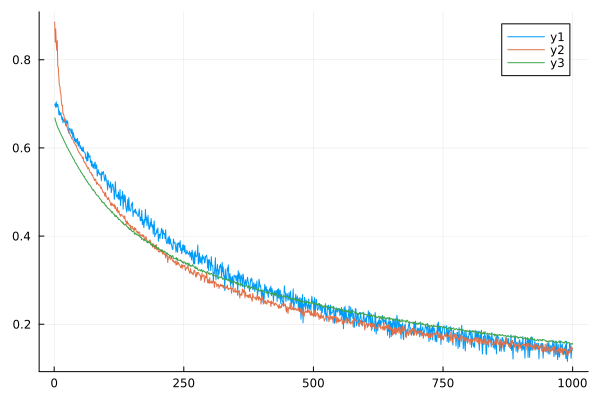

In [77]:
plot(error_dict[1])
plot!(error_dict[2])
plot!(error_dict[3])

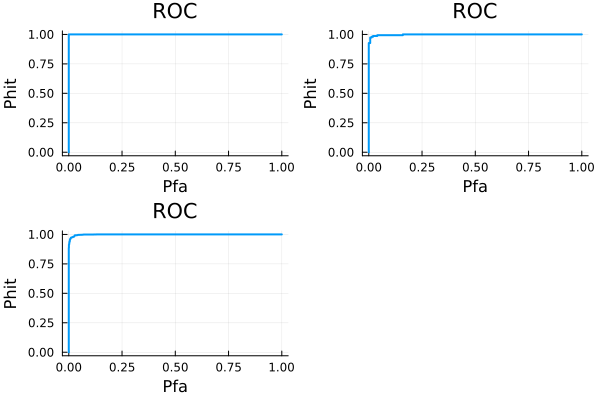

In [78]:
nn=1
plots_tmp = []
for nn in 1:3
    tar = res_dict[nn]["testingTargets"]
    non = res_dict[nn]["testingNonTargets"]
    r = roc(tar, non)
    push!( plots_tmp , plot(r, traditional=true , linewidth = 2) )  
end
plot(plots_tmp...)

In [79]:
[ res_dict[nn]["testing"] for nn in 1:length(res_dict) ]

3-element Vector{Float64}:
 1.0
 0.9666666666666667
 0.969